In [4]:
!pip install azure-storage-blob

  Using cached cffi-1.17.1-cp310-cp310-win_amd64.whl.metadata (1.6 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
   ---------------------------------------- 0.0/3.4 MB ? eta -:--:--
   ------------------------ --------------- 2.1/3.4 MB 9.8 MB/s eta 0:00:01
   ---------------------------------------- 3.4/3.4 MB 10.0 MB/s eta 0:00:00
Using cached cffi-1.17.1-cp310-cp310-win_amd64.whl (181 kB)
Using cached pycparser-2.22-py3-none-any.whl (117 kB)

   ------ --------------------------------- 1/6 [isodate]
   -------------------- ------------------- 3/6 [azure-core]
   -------------------- ------------------- 3/6 [azure-core]
   -------------------------- ------------- 4/6 [cryptography]
   -------------------------- ------------- 4/6 [cryptography]
   --------------------------------- ------ 5/6 [azure-storage-blob]
   --------------------------------- ------ 5/6 [azure-storage-blob]
   ---------------------------------------- 6/6 [azure-storage-blob]



In [14]:
from azure.storage.blob import BlobServiceClient
import os
import zipfile

container_name='braindatamri'
blob_prefix='Brain_Cancer raw MRI data'
local_dir='MRI_data_from_azure'
conn_str='DefaultEndpointsProtocol=https;AccountName=firststorage921;AccountKey=Lm8ahvyqqY8MNZ9haIyaZvymf7AjbatYMb5ewcyQ9EYk/N//5+S824MtTrfA21HmhhY04c+nKymc+ASttG85AQ==;EndpointSuffix=core.windows.net'
def download_blob(container_name,blob_prefix,local_dir,conn_str):
    service=BlobServiceClient.from_connection_string(conn_str)
    container=service.get_container_client(container_name)

    os.makedirs(local_dir,exist_ok=True)
    for blob in container.list_blobs(name_starts_with=blob_prefix):
        local_path=os.path.join(local_dir,os.path.basename(blob.name))
        with open(local_path,'wb')as f:
            f.write(container.download_blob(blob.name).readall())


download_blob(container_name,blob_prefix,local_dir,conn_str)


In [16]:

Unzip_file_path='MRI_Data'
zip_file_path='MRI_data_from_azure/Brain_Cancer raw MRI data.zip' 
def unzip_data_files(zip_file_path,Unzip_file_path):
    os.makedirs(Unzip_file_path,exist_ok=True)
    with zipfile.ZipFile(zip_file_path,'r')as ref:
        ref.extractall(path=Unzip_file_path)
        ref.close()
unzip_data_files(zip_file_path,Unzip_file_path)

##Preprocessing images to desired size


In [22]:
pip install opencv-python

   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
    --------------------------------------- 0.8/39.0 MB 6.7 MB/s eta 0:00:06
   - -------------------------------------- 1.8/39.0 MB 6.3 MB/s eta 0:00:06
   -- ------------------------------------- 2.6/39.0 MB 5.2 MB/s eta 0:00:07
   ---- ----------------------------------- 3.9/39.0 MB 5.3 MB/s eta 0:00:07
   ----- ---------------------------------- 5.5/39.0 MB 5.8 MB/s eta 0:00:06
   ------- -------------------------------- 7.1/39.0 MB 6.0 MB/s eta 0:00:06
   --------- ------------------------------ 9.2/39.0 MB 6.6 MB/s eta 0:00:05
   ----------- ---------------------------- 10.7/39.0 MB 6.6 MB/s eta 0:00:05
   ------------ --------------------------- 12.6/39.0 MB 7.0 MB/s eta 0:00:04
   --------------- ------------------------ 14.7/39.0 MB 7.3 MB/s eta 0:00:04
   ---------------- ----------------------- 16.0/39.0 MB 7.1 MB/s eta 0:00:04
   ------------------ --------------------- 17.6/39.0 MB 7.2 MB/s eta 0:00:03
 

In [7]:
import PIL
import cv2
import numpy as np
import os

image_array=[]
label_array=[]
label_dict={}
count_of_classes={}
image_dir_path='MRI_Data\Brain_Cancer'

for idx,label in enumerate(os.listdir(image_dir_path)):
    label_path=os.path.join(image_dir_path,label)
    if os.path.isdir(label_path):
        label_dict[label]=idx
        count=0
        for img_file in os.listdir(label_path):
            count_of_classes[label]=count+1
            image_path=os.path.join(label_path,img_file)
            try:
                img=cv2.imread(image_path)
                if img is not None:
                    img=cv2.resize(img,(225,225))
                    image_array.append(img)
                    label_array.append(idx)
                count=count+1
            except Exception as e:
                print(e)

image_array =np.array(image_array)
label_array=np.array(label_array)



In [2]:
import os
import glob
from sklearn.model_selection import train_test_split

# Folder containing class subfolders
data_dir = "MRI_Data/Brain_Cancer"

# Map class names to index
classes = ['brain_glioma', 'brain_menin', 'brain_tumor']
class_to_index = {cls: idx for idx, cls in enumerate(classes)}

# Collect image paths and integer labels
all_files = []
labels = []

for cls in classes:
    class_path = os.path.join(data_dir, cls)
    image_paths = glob.glob(os.path.join(class_path, "*"))
    all_files.extend(image_paths)
    labels.extend([class_to_index[cls]] * len(image_paths))  # ✅ integer labels

train_files,test_files,y_train,y_test=train_test_split(all_files,labels,test_size=0.1,stratify=labels, random_state=42)
train_files,val_files,y_train,y_val=train_test_split(train_files,y_train,test_size=0.1,stratify=y_train, random_state=42)




#Albumentations

In [3]:
import albumentations as A

train_aug=A.Compose([
A.RandomResizedCrop((224,224),scale=(0.8,1.0),p=0.5),
A.HorizontalFlip(p=0.5),
A.RandomBrightnessContrast(p=0.5),
A.Rotate(limit=15, p=0.5),
A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
A.Resize(224, 224), 
A.Normalize()
])

val_aug = A.Compose([
    A.Resize(224, 224),
    A.Normalize()
])

c:\Users\santh\anaconda3\envs\clsuter\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
pip install pydicom

In [ ]:
import cv2
import pydicom
def read_image(path):
    ext=os.path.splitext(path)[-1].lower()
    if ext=='.dcm':
        ds=pydicom.dcmread(path)
        img=ds.pixel_array
        if len(img.shape) == 2:
            img=cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        elif len(img.shape) == 3 and img.shape[-1] == 3:
            pass  # already RGB
        else:
            raise ValueError(f"Unsupported DICOM image shape: {img.shape}")
    else:
        img=cv2.imread(path)
        if img is None:
            raise FileNotFoundError(f"Could not read image: {path}")
        # Convert only if image has 3 channels
        if len(img.shape) == 3 and img.shape[-1] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        elif len(img.shape) == 2:  # Grayscale image
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img 

img=read_image('MRI_Data/Brain_Cancer/brain_menin/brain_menin_0001.jpg')       

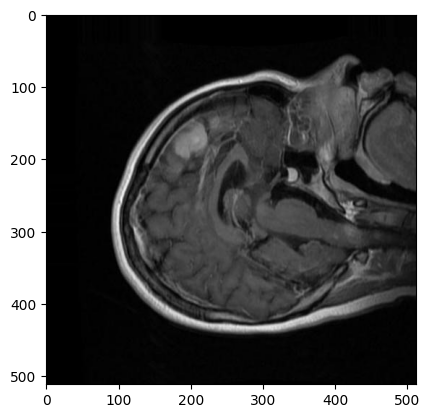

In [6]:
import matplotlib.pyplot as plt
plt.imshow(img) 

In [1]:
pwd

'd:\\Computer_Vision\\Brain_Classification\\Image_classification'

(512, 512)


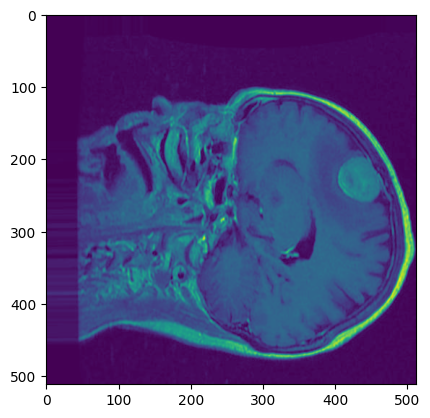

In [9]:
import cv2
import matplotlib.pyplot as plt
img=cv2.imread('MRI_Data/Brain_Cancer/brain_menin/brain_menin_0009.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
print(img.shape)  # Display the shape of the image


In [9]:
#Process images
import tensorflow as tf
def process_image(path,label,augment=True):
    path=path.numpy().decode()
    img=read_image(path)
    aug=train_aug if augment else val_aug
    img=aug(image=img)['image']
    return img.astype(np.float32),label 

def tf_augment(augment=True):
    def wrapper(path,label):
        img,label=tf.py_function(lambda p,l:process_image(p,l,augment),
                                 [path,label],
                                 [tf.float32,tf.int32]
                                 )
        img.set_shape([224,224,3])
        label.set_shape([])
        return img,label
    return wrapper


In [10]:
def create_dataset(paths, labels, batch_size=32, augment=True, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ds.map(tf_augment(augment), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = create_dataset(train_files, y_train, augment=True)
val_ds = create_dataset(val_files, y_val, augment=False)
test_ds = create_dataset(test_files, y_test, augment=False)


In [12]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
class_weigths=compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)
class_weigths_dict=dict(enumerate(class_weigths))
class_weigths_dict

{0: np.float64(1.0073937153419594),
 1: np.float64(1.0073937153419594),
 2: np.float64(0.9855334538878843)}

In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers,models

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze for transfer learning

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # Multi-class
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
import os
import yaml
with open('config/params.yaml', 'r') as file:
    config = yaml.safe_load(file)['model_builder']
os.makedirs(os.path.dirname(config['model_save_path']), exist_ok=True)
model.save(config['model_save_path'])

In [45]:
import mlflow
from tensorflow.keras.models import load_model
# with mlflow.start_run(run_name='Resnet50_Model_Training') as run:
#     print(run.info.run_id)
model=load_model("models/resenet_model.h5")
mlflow.keras.save_model(model,path='models/')

2025/08/06 16:27:15 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


In [57]:
import tensorflow as tf
model_dir = os.getenv("AZUREML_MODEL_DIR", "outputs")  # fallback to 'outputs' folder locally
model_path = os.path.join(model_dir, "model\data\model.keras")
model = tf.keras.models.load_model(model_path)
model

c:\Users\santh\anaconda3\envs\clsuter\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<Sequential name=sequential, built=True>

In [33]:
pip install azureml-core



  Using cached azureml_core-1.60.0.post1-py3-none-any.whl.metadata (3.4 kB)
  Using cached backports.tempfile-1.0-py2.py3-none-any.whl.metadata (2.3 kB)
  Using cached pathspec-0.12.1-py3-none-any.whl.metadata (21 kB)
  Using cached knack-0.12.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached pkginfo-1.12.1.2-py3-none-any.whl.metadata (13 kB)
  Using cached argcomplete-3.6.2-py3-none-any.whl.metadata (16 kB)
  Using cached humanfriendly-10.0-py2.py3-none-any.whl.metadata (9.2 kB)
  Using cached paramiko-3.5.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached azure_mgmt_resource-24.0.0-py3-none-any.whl.metadata (43 kB)
  Using cached azure_mgmt_containerregistry-13.0.0-py3-none-any.whl.metadata (25 kB)
  Using cached azure_mgmt_storage-23.0.0-py3-none-any.whl.metadata (33 kB)
  Using cached azure_mgmt_keyvault-11.0.0-py3-none-any.whl.metadata (16 kB)
  Using cached azure_mgmt_authorization-4.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached azure_mgmt_network-29.0.0-py3-none-any.w

In [36]:
from azureml.core import Workspace
import mlflow

ws = Workspace(
    subscription_id="a218765d-a387-411d-9f0e-ffeeb0dfcecc",  # replace with your subscription ID
    resource_group="MyResource1",  # replace with your resource group name
    workspace_name="MRI_Data_CNN"  # replace with your workspace name
)  # or manually define subscription, resource_group, workspace_name

mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
mlflow.set_experiment("Resnet50_Model_Training")
mlflow.start_run()
mlflow.log_param("model_name", "ResNet50")


Performing interactive authentication. Please follow the instructions on the terminal.
Interactive authentication successfully completed.


2025/08/03 20:33:32 INFO mlflow.tracking.fluent: Experiment with name 'Resnet50_Model_Training' does not exist. Creating a new experiment.


'ResNet50'

In [ ]:
# model.fit(train_ds,validation_data=val_ds,epochs=10,class_weight=class_weigths_dict)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.6995 - loss: 0.7027 - val_accuracy: 0.8349 - val_loss: 0.4919
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2358s 15s/step - accuracy: 0.7278 - loss: 0.6535 - val_accuracy: 0.8606 - val_loss: 0.4169
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 683s 4s/step - accuracy: 0.7505 - loss: 0.5971 - val_accuracy: 0.8624 - val_loss: 0.4243
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.7749 - loss: 0.5701 - val_accuracy: 0.8495 - val_loss: 0.4237
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.7687 - loss: 0.5736 - val_accuracy: 0.8495 - val_loss: 0.4143
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.7658 - loss: 0.5561 - val_accuracy: 0.8495 - val_loss: 0.4118
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.7783 - loss: 0.5417 - val_accuracy: 0.8202 - val_loss: 0.4203
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.7713 - loss: 0.5394 - val_ac

In [ ]:
# test_loss, test_acc = model.evaluate(test_ds)
# print(f"Test Accuracy: {test_acc:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 956ms/step - accuracy: 0.8358 - loss: 0.4131
Test Accuracy: 0.8267


In [ ]:
model.get_layer('resnet50').trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=5, class_weight=class_weigths_dict)

    # 7. Evaluate and export
acc = model.evaluate(test_ds)[1]
print(f"Test accuracy: {acc:.4f}")

Epoch 1/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 885s 6s/step - accuracy: 0.5066 - loss: 1.1234 - val_accuracy: 0.3321 - val_loss: 2.0214
Epoch 2/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 1015s 7s/step - accuracy: 0.8522 - loss: 0.4029 - val_accuracy: 0.3835 - val_loss: 1.9585
Epoch 3/5
140/154 ━━━━━━━━━━━━━━━━━━━━ 2:50 12s/step - accuracy: 0.8949 - loss: 0.2876

In [8]:
counts = dict(zip(*np.unique(label_array, return_counts=True)))
counts

{np.int64(0): np.int64(2004),
 np.int64(1): np.int64(2004),
 np.int64(2): np.int64(2048)}

In [53]:
target = max(counts.values())
target

np.int64(2048)

In [ ]:
# pip install albumentations

In [12]:
pip install tensorflow

  You can safely remove it manually.
  You can safely remove it manually.



  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/375.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/375.7 MB ? eta -:--:--
   ---------------------------------------- 0.5/375.7 MB 2.1 MB/s eta 0:02:59
   ---------------------------------------- 1.0/375.7 MB 2.2 MB/s eta 0:02:52
   ---------------------------------------- 1.3/375.7 MB 1.9 MB/s eta 0:03:22
   ---------------------------------------- 1.6/375.7 MB 1.8 MB

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_Datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
counts = dict(zip(*np.unique(labels_aug, return_counts=True)))
counts

6056

In [13]:
pip install dotenv

  Using cached dotenv-0.9.9-py2.py3-none-any.whl.metadata (279 bytes)
  Using cached python_dotenv-1.1.1-py3-none-any.whl.metadata (24 kB)
Using cached dotenv-0.9.9-py2.py3-none-any.whl (1.9 kB)
Using cached python_dotenv-1.1.1-py3-none-any.whl (20 kB)

   ---------------------------------------- 2/2 [dotenv]

Note: you may need to restart the kernel to use updated packages.


In [20]:
import yaml
from Components.data_ingestion import DataIngestion
from entity.artifact_entity import DataIngestionArtifact
from dotenv import load_dotenv
import albumentations as A
load_dotenv()
class DataAugmentation:
    def __init__(self,data_ingestion_artifact:DataIngestionArtifact,config_path='config/params.yaml'):
        with open(config_path,'r') as file:
            self.config=yaml.safe_load(file)['data_augmentation']
        print(self.config)
        self.data_ingestion_artifact = DataIngestionArtifact
        self.train_aug=A.Compose(self.config['data_augmentation']['train_aug'])
        print(train_aug)
        self.val_aug=A.Compose(self.config['data_augmentation']['val_aug'])
        print(val_aug)

In [21]:
DataAugmentation(data_ingestion_artifact=DataIngestionArtifact)

{'test_size': 0.2, 'random_state': 42, 'batch_size': 32, 'image_size': '(224, 224)', 'train_aug': ['A.RandomResizedCrop((224', '224)', 'scale=(0.8', '1.0)', 'p=0.5)', 'A.HorizontalFlip(p=0.5)', 'A.RandomBrightnessContrast(p=0.5)', 'A.Rotate(limit=15', 'p=0.5)', 'A.ShiftScaleRotate(shift_limit=0.05', 'scale_limit=0.1', 'rotate_limit=10', 'p=0.5)', 'A.Resize(224', '224)', 'A.Normalize()'], 'val_aug': ['A.Resize(224', '224)', 'A.Normalize()']}


KeyError: 'data_augmentation'

In [59]:
pip install azure-ai-ml azure-identity 

  Using cached azure_ai_ml-1.28.1-py3-none-any.whl.metadata (39 kB)
  Using cached marshmallow-3.26.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached jsonschema-4.25.0-py3-none-any.whl.metadata (7.7 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached strictyaml-1.7.3-py3-none-any.whl.metadata (11 kB)
  Using cached azure_storage_file_share-12.22.0-py3-none-any.whl.metadata (50 kB)
  Using cached azure_storage_file_datalake-12.21.0-py3-none-any.whl.metadata (16 kB)
  Using cached pydash-8.0.5-py3-none-any.whl.metadata (4.5 kB)
  Using cached azure_monitor_opentelemetry-1.6.13-py3-none-any.whl.metadata (21 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached jsonschema_specifications-2025.4.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached referencing-0.36.2-py3-none-any.whl.metadata (2.8 kB)
  Using cached azure_storage_blob-12.26.0-py3-none-any.whl.metadata (26 kB)
  Using cached azure_core_tracing_opentelemetry-1.0.0b12-py3-n

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
azureml-mlflow 1.60.0.post1 requires azure-storage-blob<=12.19.0,>=12.5.0, but you have azure-storage-blob 12.26.0 which is incompatible.


In [66]:
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient
from azure.ai.ml.entities import Workspace
import os
# Fill these in
subscription_id = os.getenv('SUBSCRIPTION_ID')
resource_group = os.getenv('RESOURCE_GROUP')
workspace_name = "mynew-mlworkspace"
# storage_account = "firststorage921"  # Or leave blank to auto-create

ml_client = MLClient(DefaultAzureCredential(), subscription_id, resource_group)

workspace = Workspace(
    name=workspace_name,
    location="eastus",  # or your preferred region
    display_name="My New Workspace",
    description="Recreated due to deleted blob issue",
    # storage_account=storage_account
)

ml_client.workspaces.begin_create(workspace).result()
print("✅ Workspace created!")

The deployment request mynew-mlworkspace-9319 was accepted. ARM deployment URI for reference: 
https://portal.azure.com//#blade/HubsExtension/DeploymentDetailsBlade/overview/id/%2Fsubscriptions%2Fa218765d-a387-411d-9f0e-ffeeb0dfcecc%2FresourceGroups%2FMyResource1%2Fproviders%2FMicrosoft.Resources%2Fdeployments%2Fmynew-mlworkspace-9319
Creating Storage Account: (mynewmlwstorage09c991653  ) ..  Done (19s)
Creating Key Vault: (mynewmlwkeyvaulta94a65c1  )  Done (17s)
Creating Log Analytics Workspace: (mynewmlwlogalyti9f4e548b  )  Done (15s)
Creating AzureML Workspace: (mynew-mlworkspace  ) ....  Done (33s)
Creating Application Insights: (mynewmlwinsightsce6cf750  )  Done (18s)
Total time : 54s



✅ Workspace created!


In [74]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import os
ml_client = MLClient(
    credential=DefaultAzureCredential(),
    subscription_id = os.getenv('SUBSCRIPTION_ID'),
    resource_group = os.getenv('RESOURCE_GROUP'),
    workspace_name = "mynew-mlworkspace"  
)
ml_client.online_deployments.begin_delete(
    name="blue",           # This is the failed deployment name
    endpoint_name="restnet-endpoint-new"  # Your endpoint
).wait()

ResourceNotFoundError: (ResourceGroupNotFound) Resource group 'None' could not be found.
Code: ResourceGroupNotFound
Message: Resource group 'None' could not be found.

In [ ]:
pip install ipykernel

: 

In [1]:
import mlflow.keras


In [3]:
import sys
print(sys.version)

3.9.23 (main, Jun  5 2025, 13:25:08) [MSC v.1929 64 bit (AMD64)]


In [10]:
import yaml
import os
with open('config/params.yaml', 'r') as file:
    config = yaml.safe_load(file)['model_builder']
path=os.path.dirname(config['keras_model_path'])
mlflow.keras.log_model(model,artifact_path=path)

NameError: name 'model' is not defined

In [25]:
from azureml.core import Workspace
import mlflow
import os
from dotenv import load_dotenv
load_dotenv()
ws = Workspace(
                    subscription_id=os.getenv("SUBSCRIPTION_ID"),
                    resource_group=os.getenv('RESOURCE_GROUP'),
                    workspace_name=os.getenv('WORKSPACE_NAME')
                )
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
from mlflow.tracking import MlflowClient
client = MlflowClient()
runs = client.get_experiment_by_name('Resnet50_Model_Training')
client.get_experiment(runs.experiment_id)
# for run in runs:
#     print(run.run_id)
client.search_runs(runs.experiment_id)

[<Run: data=<RunData: metrics={'accuracy': 0.754950495049505,
  'f1_score': 0.7552903321375913,
  'precision': 0.7968042644417196,
  'recall': 0.754950495049505,
  'roc_auc_score': 0.9326320450471212,
  'test_accuracy': 0.7549505233764648,
  'test_loss': 0.5743211507797241}, params={}, tags={'mlflow.rootRunId': '4aa6237f-6462-4b44-9611-da569521bc45',
  'mlflow.runName': 'Resnet50_Model_Training',
  'mlflow.user': 'meena reddy'}>, info=<RunInfo: artifact_uri='', end_time=1754719305964, experiment_id='4f17d132-4ae6-4a92-bd70-12aae8c54ab5', lifecycle_stage='active', run_id='4aa6237f-6462-4b44-9611-da569521bc45', run_name='Resnet50_Model_Training', run_uuid='4aa6237f-6462-4b44-9611-da569521bc45', start_time=1754719199994, status='FINISHED', user_id='meena reddy'>, inputs=<RunInputs: dataset_inputs=[]>>]

In [26]:
model_uri="runs:/4aa6237f-6462-4b44-9611-da569521bc45/model"
mlflow.keras.load_model(model_uri)


c:\Users\santh\anaconda3\envs\img_cv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
from tensorflow.keras.models import load_model

model=load_model('outputs/data/model')
model

In [31]:
import base64
with open("MRI_data/Brain_Cancer/brain_tumor/brain_tumor_0001.jpg", "rb") as f:
    print(base64.b64encode(f.read()).decode("utf-8"))


/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAIAAgADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD5/qzbnmq1TwHkUAbEZ+UVMfu1XhOUFTj7tACfwVNEeBUI6GpYgcDjvQA5uHNRyjpUsikNnBqNgZCVUcigCKI4epJh96rcWlvgSO2BVk6fEYi7MTntQBDZnMa/Srdodt0h7VJpttGZBEV/hyCTVA6pFDPNCpG5WxmgDZuonkjm

In [33]:
from pathlib import Path
Path(f"\MRI_data\Brain_Cancer\brain_glioma\brain_glioma_0001.jpg")

WindowsPath('/MRI_data/Brain_Cancer\x08rain_glioma\x08rain_glioma_0001.jpg')